In [4]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image 

In [5]:
# Load trained inceptionNet model, for more information on Transfer Learning, check previous case studies
base_model = tf.keras.applications.InceptionV3(include_top = False, weights = 'imagenet')

In [6]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
image = Image.open("/CreativeAI/img_0.jpg")

image.save("img_0.jpg")

In [ ]:
Sample_Image = tf.keras.preprocessing.image.load_img('img_0.jpg')

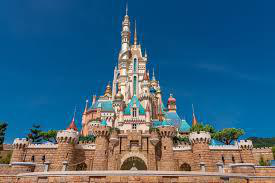

In [ ]:
Sample_Image

In [ ]:
# Convert to numpy array
Sample_Image = tf.keras.preprocessing.image.img_to_array(Sample_Image)

# Sample_Image = np.array(Sample_Image)

In [ ]:
# Confirm that the image is converted to Numpy array
type(Sample_Image)

numpy.ndarray

In [ ]:
# Obtain the max and min values
print('min pixel values = {}, max pixel values = {}'.format(Sample_Image.min(), Sample_Image.max()))

min pixel values = 0.0, max pixel values = 255.0


In [ ]:
# Normalize the input image
Sample_Image = np.array(Sample_Image)/255.0
Sample_Image.shape

(183, 275, 3)

In [ ]:
# Let's verify normalized images values!
print('min pixel values = {}, max pixel values = {}'.format(Sample_Image.min(), Sample_Image.max()))

min pixel values = 0.0, max pixel values = 1.0


In [ ]:
# Maximize the activations of these layers

names = ['mixed3', 'mixed5', 'mixed7']

layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
deepdream_model = tf.keras.Model(inputs = base_model.input, outputs = layers)

In [ ]:
deepdream_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
# Let's run the model by feeding in our input image and taking a look at the activations "Neuron outputs"
activations = deepdream_model(Sample_Image)
activations

[<tf.Tensor: shape=(1, 9, 15, 768), dtype=float32, numpy=
 array([[[[0.        , 0.        , 0.        , ..., 0.        ,
           0.2386268 , 0.55704355],
          [0.        , 0.0656892 , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
         

In [ ]:
def calc_loss(image, model):
# Function used for loss calculations
# It works by feedforwarding the input image through the network and generate activations
# Then obtain the average and sum of those outputs

  img_batch = tf.expand_dims(image, axis=0) # Convert into batch format
  layer_activations = model(img_batch) # Run the model
  print('ACTIVATION VALUES (LAYER OUTPUT) =\n', layer_activations)
  # print('ACTIVATION SHAPE =\n', np.shape(layer_activations))

  losses = [] # accumulator to hold all the losses
  for act in layer_activations:
    loss = tf.math.reduce_mean(act) # calculate mean of each activation 
    losses.append(loss)
  
  print('LOSSES (FROM MULTIPLE ACTIVATION LAYERS) = ', losses)
  print('LOSSES SHAPE (FROM MULTIPLE ACTIVATION LAYERS) = ', np.shape(losses))
  print('SUM OF ALL LOSSES (FROM ALL SELECTED LAYERS)= ', tf.reduce_sum(losses))

  return  tf.reduce_sum(losses) # Calculate sum 

In [ ]:
loss = calc_loss(tf.Variable(Sample_Image), deepdream_model)

ACTIVATION VALUES (LAYER OUTPUT) =
 [<tf.Tensor: shape=(1, 9, 15, 768), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.2386268 , 0.55704355],
         [0.        , 0.0656892 , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
        

In [ ]:
loss # Sum up the losses from both activations

<tf.Tensor: shape=(), dtype=float32, numpy=0.77290064>

In [ ]:
# When you annotate a function with tf.function, the function can be called like any other python defined function. 
# The benefit is that it will be compiled into a graph so it will be much faster and could be executed over TPU/GPU

@tf.function
def deepdream(model, image, step_size):
    with tf.GradientTape() as tape:
      # This needs gradients relative to `img`
      # `GradientTape` only watches `tf.Variable`s by default
      tape.watch(image)
      loss = calc_loss(image, model) # call the function that calculate the loss 

    # Calculate the gradient of the loss with respect to the pixels of the input image.
    # The syntax is as follows: dy_dx = g.gradient(y, x) 
    gradients = tape.gradient(loss, image)

    print('GRADIENTS =\n', gradients)
    print('GRADIENTS SHAPE =\n', np.shape(gradients))

    # tf.math.reduce_std computes the standard deviation of elements across dimensions of a tensor
    gradients /= tf.math.reduce_std(gradients)  

    # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
    # You can update the image by directly adding the gradients (because they're the same shape!)
    image = image + gradients * step_size
    image = tf.clip_by_value(image, -1, 1)

    return loss, image

In [ ]:
def run_deep_dream_simple(model, image, steps = 100, step_size = 0.01):
  # Convert from uint8 to the range expected by the model.
  image = tf.keras.applications.inception_v3.preprocess_input(image)

  for step in range(steps):
    loss, image = deepdream(model, image, step_size)
    
    if step % 100 == 0:
      plt.figure(figsize=(12,12))
      plt.imshow(deprocess(image))
      plt.show()
      print ("Step {}, loss {}".format(step, loss))

  # clear_output(wait=True)
  plt.figure(figsize=(12,12))
  plt.imshow(deprocess(image))
  plt.show()

  return deprocess(image)

In [ ]:
def deprocess(image):
  image = 255*(image + 1.0)/2.0
  return tf.cast(image, tf.uint8)

In [ ]:
Sample_Image.shape

TensorShape([183, 275, 3])

In [ ]:
# Let's Load the image again and convert it to Numpy array 
Sample_Image = np.array(tf.keras.preprocessing.image.load_img('img_0.jpg'))
dream_img = run_deep_dream_simple(model = deepdream_model, image = Sample_Image, steps = 1000, step_size = 0.01)


In [ ]:
image = tf.keras.preprocessing.image.load_img("img_0.jpg")

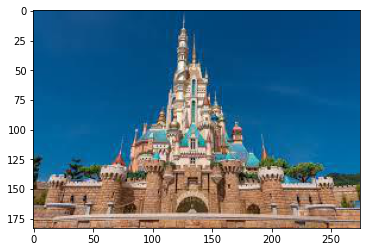

In [ ]:
plt.imshow(image)

In [ ]:
# Name of the folder
dream_name = 'disneyland'

In [ ]:
# Blended image dimension

x_size = 910 # larger the image longer is going to take to fetch the frames 
y_size = 605

In [ ]:
# Define Counters 
created_count = 0
max_count = 50

In [ ]:
# This helper function loads an image and returns it as a numpy array of floating points

def load_image(filename):
    image = PIL.Image.open(filename)
    return np.float32(image)

In [ ]:
for i in range(0, 50):
    # Make sure to create a new folder entitled 'mars_eiffel' and place img_0 in it
    # Get into the dream directory and look for the number of images and then figure out what is the latest image. Hence this 
    # image we are going to start with and let it dream on and on
     
    if os.path.isfile('/{}/img_{}.jpg'.format(dream_name, i+1)):
        print("{} present already, continue fetching the frames...".format(i+1))
        
    else:
        # Call the load image funtion
        img_result = load_image('/{}/img_{}.jpg'.format(dream_name, i))

    
        # Zoom the image 
        x_zoom = 2 # this indicates how quick the zoom is 
        y_zoom = 1
        
        # Chop off the edges of the image and resize the image back to the original shape. This gives the visual changes of a zoom
        img_result = img_result[0+x_zoom : y_size-y_zoom, 0+y_zoom : x_size-x_zoom]
        img_result = cv2.resize(img_result, (x_size, y_size))
        
        # Adjust the RGB value of the image
        img_result[:, :, 0] += 2  # red
        img_result[:, :, 1] += 2  # green
        img_result[:, :, 2] += 2  # blue
        
        # Deep dream model  
        img_result = run_deep_dream_simple(model = deepdream_model, image = img_result, steps = 100, step_size = 0.1)
        
        # Clip the image, convert the datatype of the array, and then convert to an actual image. 
        img_result = np.clip(img_result, 0.0, 255.0)
        img_result = img_result.astype(np.uint8)
        result = PIL.Image.fromarray(img_result, mode='RGB')
        
        # Save all the frames in the dream location
        result.save(r'/{}/img_{}.jpg'.format(dream_name, i+1))
        
        created_count += 1
        if created_count > max_count:
            break

In [10]:
import cv2
import numpy as np
import glob
 
img_array = []
for filename in glob.glob('disneyland/*.jpg'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, (910, 605))
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()